In [6]:
from clearml import Task
import numpy as np
import random
import os
import optuna

import joblib
import pandas as pd
import optuna.visualization as vis
import matplotlib.pyplot as plt

from pathlib import Path
from clearml import Logger
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

from src import data_preprocessing as dp
from src import pipeline as pl
from src import feature_engineering as fe
from src.model_evaluation import evaluate
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED) 

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)


In [7]:
# 1. Load raw Data
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")


# 2. basic preprocessing for all data set
df = dp.basic_preprocessing(df=df)

# 3. chia train, val, test (tỉ lệ 70/15/15)
target_col = 'temp'
train_size = 0.7
val_size = 0.15
n = len(df)

train_df = df.iloc[:int(train_size*n)]
val_df = df.iloc[int(train_size*n):int((train_size+val_size)*n)]
test_df = df.iloc[int((train_size+val_size)*n):]

# 4. Fit và transform trên preprocessing pipeline
pipeline1 = pl.build_preprocessing_pipeline()

# fit trên train
pipeline1.fit(train_df)

# transform 
train_processed = pipeline1.transform(train_df)
val_processed = pipeline1.transform(val_df)
test_processed = pipeline1.transform(test_df)


# Tạo feature engineering
column_lag = ['temp','tempmax', 'tempmin', 'dew', 'humidity', 'precip',
    'precipprob', 'precipcover', 'windgust', 'windspeed',
    'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
    'pressure_temp_index', 'wind_temp_index', 'temp_range', 'dew_spread']

train_feat = fe.feature_engineering(train_processed, column= column_lag)
val_feat = fe.feature_engineering(val_processed, column= column_lag)
test_feat = fe.feature_engineering(test_processed, column= column_lag)
print(train_feat.shape)

 Loaded data with shape: (3660, 33)
Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'
(2562, 258)


In [8]:
# Chia X, y riêng biệt
X_train, y_train = train_feat.drop(columns=[target_col]), train_df[target_col]
X_val, y_val = val_feat.drop(columns=[target_col]), val_df[target_col]
X_test, y_test = test_feat.drop(columns=[target_col]), test_df[target_col]

print(f"Train: {X_train.shape, y_train.shape}, Val: {X_val.shape, y_val.shape}, Test: {X_test.shape, y_test.shape}")

Train: ((2562, 257), (2562,)), Val: ((549, 257), (549,)), Test: ((549, 257), (549,))


In [9]:
# không để drop highly correlated ở preprocessing nữa, chuyển sang ở feature selection
from src import feature_selection as fs
dropHighCorr = fs.DropHighlyCorrelated()
dropHighCorr.fit(X_train)
X_train = dropHighCorr.transform(X_train)
X_val = dropHighCorr.transform(X_val)
X_test = dropHighCorr.transform(X_test)


In [10]:
fs_pipeline_RF = pl.build_RF_featture_engineering_pipeline()

In [11]:
# RF importance
# fit trên train
X_train = fs_pipeline_RF.fit_transform(X_train, y_train)

# transform 
X_train = fs_pipeline_RF.transform(X_train)
X_val = fs_pipeline_RF.transform(X_val)
X_test = fs_pipeline_RF.transform(X_test)

In [12]:
X_train.columns

Index(['feelslike_lag_1', 'solar_temp_index_lag_1', 'windspeed_lag_1',
       'humidity_lag_1', 'sunrise_lag_1', 'windgust_lag_1',
       'pressure_temp_index_roll_mean_14', 'winddir_lag_1', 'dew_spread_lag_1',
       'wind_variability_lag_1', 'sealevelpressure_roll_mean_14',
       'day_length_lag_1', 'wind_temp_index_lag_1', 'temp_range_lag_1',
       'tempmax_lag_4', 'precip_lag_1', 'visibility_lag_1',
       'sealevelpressure_roll_std_7', 'solarradiation_roll_std_14',
       'sealevelpressure_lag_7', 'pressure_temp_index_lag_7',
       'solarradiation_lag_2', 'windgust_roll_mean_3', 'visibility_lag_3',
       'temp_roll_std_7', 'pressure_temp_index_roll_std_14',
       'pressure_temp_index_lag_6', 'windgust_roll_std_3',
       'visibility_roll_std_3', 'pressure_temp_index_roll_std_3'],
      dtype='object')

In [ ]:
# chưa có feature selection
# 1. RF
## Default
# a. Validation metrics: {'RMSE': 2.1278075895022885, 'R2': 0.8297628223226209, 'MAPE': 7.013125189028322}
# b. Test metrics: {'RMSE': 1.7168173002419687, 'R2': 0.8638144750921892, 'MAPE': 5.359437239042012}

## Best parameter
# Validation metrics: {'RMSE': 1.6388776242029133, 'R2': 0.8990089808287993, 'MAPE': 5.741406234570231}
# Test metrics: {'RMSE': 1.4337918013739446, 'R2': 0.9050150119360206, 'MAPE': 4.584963631819218}


# 2. Extra Tree
## Default
# Validation metrics: {'RMSE': 1.5501069852687441, 'R2': 0.9096531427481926, 'MAPE': 5.289823867518864}
# Test metrics: {'RMSE': 1.4094799560393934, 'R2': 0.9082088955219491, 'MAPE': 4.494487229026149}

## Best parameter
# Validation metrics: {'RMSE': 1.4981094962144423, 'R2': 0.9156127533286983, 'MAPE': 5.13799909932879}
# Test metrics: {'RMSE': 1.3558239003827515, 'R2': 0.9150644784751033, 'MAPE': 4.317549688535942}

# 3. GB
## Default
# Validation metrics: {'RMSE': 1.479398688181336, 'R2': 0.9177075178532362, 'MAPE': 5.0692414857715775}
# Test metrics: {'RMSE': 1.3534994389764416, 'R2': 0.9153554603683042, 'MAPE': 4.1845167790637126}

## Best parameter
# Validation metrics: {'RMSE': 1.5011458815829, 'R2': 0.9152703326059204, 'MAPE': 5.158944802837902}
# Test metrics: {'RMSE': 1.3430800523462543, 'R2': 0.9166536500947113, 'MAPE': 4.216884591360309}
Task.current_task().close()

### Random Forest

In [ ]:
# ! pip install plotly
# === 1️ Khởi tạo Task (1 study = 1 Task) ===
# Khởi tạo task mới cho mỗi lần experiemt/ study bằng Task.create ...
# Hoặc nếu muốn tiếp tục với task cũ thì pass task id vào Task.get_task ...

# mấy đứa tự tạo task mới cũng được, không thì cop id trong clearml
# Nhớ đổi tên instance đi nhá, vd như task_1, logger_1
# Tạo task mới trong project Temperature Forecasting
task = Task.init(
    project_name="Temperature Forecasting",     # tên project (nếu chưa có sẽ tự tạo)
    task_name="RF Optuna Tuning", # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print("✅ Task created successfully!")
print("Task ID:", task.id)


ClearML Task: created new task id=ce115461cca2450fb4aa5ce1434fdb56
ClearML results page: https://app.clear.ml/projects/01d8ce929f0243de9a9d3adf48970730/experiments/ce115461cca2450fb4aa5ce1434fdb56/output/log
Task ID: ce115461cca2450fb4aa5ce1434fdb56


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
2025-10-21 18:20:12,867 - clearml.storage - INFO - Uploading: 23.45MB from c:/Users/Admin/Documents/ML/group1/models/Tuning_RF_model.pkl


███████████████████████████████ 100% | 23.45/23.45 MB [01:55<00:00,  4.92s/MB]: 
███████████████████████████████ 100% | 23.45/23.45 MB [01:56<00:00,  4.97s/MB]: 


In [16]:
task = Task.get_task(task_id="ce115461cca2450fb4aa5ce1434fdb56")
logger = task.get_logger()

In [17]:
## A. default hyper parameter
# 1. fit 
model1 = RandomForestRegressor(n_estimators = 100, min_samples_split=2, min_samples_leaf=1,min_impurity_decrease=0, 
                               max_depth= 7, max_features= None, bootstrap= False, oob_score= False, 
                               max_leaf_nodes= None, max_samples= None, random_state= 42, n_jobs= -1
                               )
model1.fit(X_train, y_train) 

# 2. predict
y_pred_val = model1.predict(X_val) 
y_pred_test = model1.predict(X_test)

In [18]:
# Lấy feature importance
importances = model1.feature_importances_

# Tạo DataFrame hiển thị
feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#print(feat_importance)

Text(0.5, 0, 'Importance')

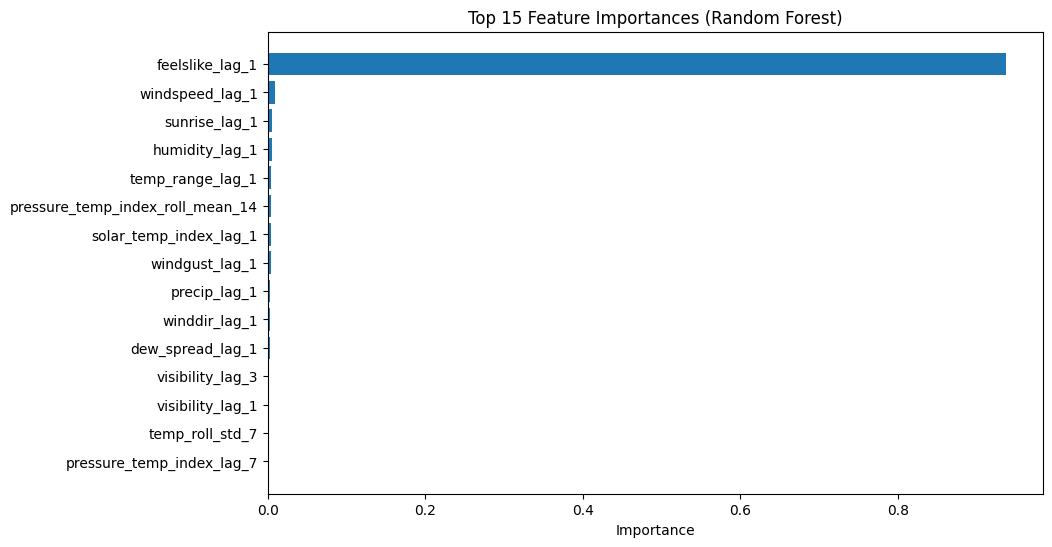

In [19]:
plt.figure(figsize=(10, 6))
plt.barh(feat_importance['Feature'][:15], feat_importance['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
#plt.show()


In [20]:
# Đánh giá sơ bộ trước khi tune

# 3. Evaluate on validation
default_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", default_val_metrics)

# 4. Evaluate on test
default_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", default_test_metrics)

# 5. Save model 
model_path = r'models/RF_model.pkl' 
joblib.dump(model1, model_path)
print(f"RandomForest model saved to {model_path}")

# 6 Log lên ClearML
logger.report_scalar("Default Metrics", "RMSE_val", default_val_metrics["RMSE"], iteration=0)
logger.report_scalar("Default Metrics", "R2_val", default_val_metrics["R2"], iteration=0)
logger.report_scalar("Default Metrics", "MAPE_val", default_val_metrics["MAPE"], iteration=0)
logger.report_scalar("Default Metrics", "RMSE_test", default_test_metrics["RMSE"], iteration=0)
logger.report_scalar("Default Metrics", "R2_test", default_test_metrics["R2"], iteration=0)
logger.report_scalar("Default Metrics", "MAPE_test", default_test_metrics["MAPE"], iteration=0)


task.upload_artifact("Default Metrics", {
    "Validation": default_val_metrics,
    "Test": default_test_metrics
})


Validation metrics: {'RMSE': 1.7668779833722073, 'R2': 0.8826176441037896, 'MAPE': 6.0101795956807775}
Test metrics: {'RMSE': 1.6188276477495223, 'R2': 0.8789167656636432, 'MAPE': 5.108976073760763}
RandomForest model saved to models/RF_model.pkl


True

In [21]:
## B hyper parameter tuning
# === 1 Định nghĩa objective của optuna ===
def objective(trial):
    # Hyperparameter space
    params = {
    'n_estimators' : trial.suggest_int('n_estimators', 400, 1000),
    'max_depth' : trial.suggest_int('max_depth', 15, 35),
    'min_samples_split' : trial.suggest_int('min_samples_split', 5, 20),
    'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 3, 8),
    'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', 0.001, 0.5),
    'max_features' : trial.suggest_categorical('max_features', ['sqrt']),
    'bootstrap' : False,
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 400, 700),
    'random_state' : 42, 
    'n_jobs' : -1 
    }

    # Time series CV
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        
        # Model
        model = RandomForestRegressor(**params)
        model.fit(X_tr, y_tr)
        y_pred_val = model.predict(X_val)

        metrics = evaluate(y_val, y_pred_val)
        rmse_scores.append(metrics['RMSE'])
    
    mean_rmse = np.mean(rmse_scores)

    # === 2 Log thông tin của trial lên ClearML ===
    # (a) Log RMSE cho mỗi trial
    logger.report_scalar(title = 'Optuna Tuning', series = 'Trial RMSE', value = mean_rmse, iteration = trial.number)

    # (b) Log toàn bộ tham số của trial (bảng tóm tắt)
    params_table = pd.DataFrame([params])
    logger.report_table(title=f"Trial {trial.number} Parameters", series="params", iteration=trial.number, table_plot=params_table)

    # Trả về RMSE trung bình của các cv để Optuna minimize
    return mean_rmse


In [22]:
# === 3 Chạy Optuna study ===
study = optuna.create_study(direction='minimize', sampler=sampler)  # minimize RMSE
study.optimize(objective, n_trials=50)
print("Best parameters:", study.best_trial.params)
print("Best RMSE:", study.best_value)


[I 2025-10-21 18:10:10,654] A new study created in memory with name: no-name-48ade2c4-8ba7-409e-9ab0-b0952393820b
[I 2025-10-21 18:10:20,116] Trial 0 finished with value: 1.7411685469992204 and parameters: {'n_estimators': 625, 'max_depth': 34, 'min_samples_split': 16, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.07885330158077582, 'max_features': 'sqrt', 'max_leaf_nodes': 446}. Best is trial 0 with value: 1.7411685469992204.
[I 2025-10-21 18:10:26,637] Trial 1 finished with value: 1.5948624620647043 and parameters: {'n_estimators': 434, 'max_depth': 33, 'min_samples_split': 14, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.011271662653605422, 'max_features': 'sqrt', 'max_leaf_nodes': 691}. Best is trial 1 with value: 1.5948624620647043.
[I 2025-10-21 18:10:38,568] Trial 2 finished with value: 1.8444698233316736 and parameters: {'n_estimators': 900, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.1528168792368093, 'max_features': 'sqr

Best parameters: {'n_estimators': 910, 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.003501511120214604, 'max_features': 'sqrt', 'max_leaf_nodes': 467}
Best RMSE: 1.5539649247595906


In [23]:
# === 4 Log kết quả tổng hợp ===
task.upload_artifact("Best Parameters", study.best_trial.params)

# Fit lại mô hình với best params
best_model = RandomForestRegressor(**study.best_trial.params)
best_model.fit(X_train, y_train)

# Predict
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Evaluate on validation
best_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", best_val_metrics)

# Evaluate on test
best_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", best_test_metrics)


# 6 Log lên ClearML
logger.report_scalar("Best Metrics", "RMSE_val", best_val_metrics["RMSE"], iteration=0)
logger.report_scalar("Best Metrics", "R2_val", best_val_metrics["R2"], iteration=0)
logger.report_scalar("Best Metrics", "MAPE_val", best_val_metrics["MAPE"], iteration=0)
logger.report_scalar("Best Metrics", "RMSE_test", best_test_metrics["RMSE"], iteration=0)
logger.report_scalar("Best Metrics", "R2_test", best_test_metrics["R2"], iteration=0)
logger.report_scalar("Best Metrics", "MAPE_test", best_test_metrics["MAPE"], iteration=0)


# Upload artifact tổng hợp
task.upload_artifact("Best Metrics", {
    "Validation": best_val_metrics,
    "Test": best_test_metrics
})


# Save & upload model
model_path = r'models/Tuning_RF_model.pkl' 
joblib.dump(best_model, model_path)
print(f"RandomForest model saved to {model_path}")
task.upload_artifact("Best Model", model_path)

Validation metrics: {'RMSE': 1.5668726839037717, 'R2': 0.9076882206886517, 'MAPE': 5.654116211891582}
Test metrics: {'RMSE': 1.3432516967556682, 'R2': 0.9166323455579876, 'MAPE': 4.221891882131596}
RandomForest model saved to models/Tuning_RF_model.pkl


True

In [24]:
# === 6️ Vẽ biểu đồ RMSE theo trial  ===
fig = plt.figure(figsize=(7, 4))
plt.plot([t.value for t in study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig,
    iteration=len(study.trials)
)
plt.close(fig)


In [25]:
vis.plot_optimization_history(study)


In [26]:
vis.plot_parallel_coordinate(study)

In [27]:
vis.plot_slice(study=study)

In [28]:
vis.plot_param_importances(study=study)

In [ ]:
# === 7️ Kết thúc Task ===
task.close()